/tmp/ipykernel_129846/1228141096.py:75: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


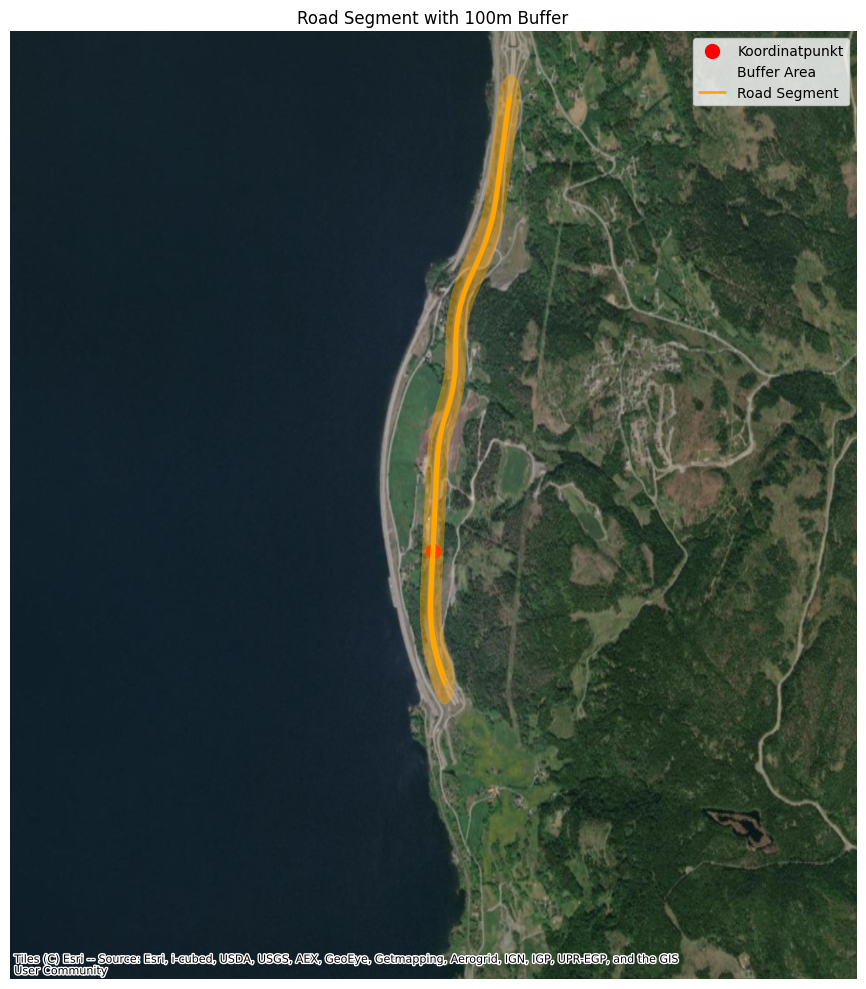

In [69]:
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union, nearest_points
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import math

def meters_to_degrees(meters):
    """
    Convert distance in meters to degrees for latitude and longitude.
    """
    # Conversion for latitude (1 degree latitude ~ 111,320 meters)
    lat_degrees = meters / 111320

    # Conversion for longitude depends on the latitude (1 degree longitude varies)
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    
    return lat_degrees, lon_degrees

def get_graph_within_distance(G, lat, lon, max_distance_meters):
    """
    Get a subgraph containing only the edges within a specified distance from a point (lat, lon).

    Args:
        G: The graph representing the road network.
        lat, lon: Coordinates of the point (latitude, longitude).
        max_distance_meters: The maximum distance to search for edges in meters.

    Returns:
        A subgraph containing only the edges within the max distance from the point.
    """
    point = Point(lon, lat)
    nearest_edge = ox.distance.nearest_edges(G, X=lon, Y=lat)
    u, v, key = nearest_edge  # u, v are nodes; key identifies the edge
    road_name = G[u][v][key].get("name", "Unnamed Road")
    edges_within_distance = []

    for u, v, key in G.edges(keys=True):
        cur_road_name = G[u][v][key].get("name", "Unnamed Road")
        geometry = G[u][v][key].get("geometry", None)
        distance_from_point = point.distance(geometry) if geometry else math.inf
        if cur_road_name == road_name and distance_from_point <= max_distance_meters:
            edges_within_distance.append((u, v, key))

    return G.edge_subgraph(edges_within_distance).copy()

lat, lon = 60.491152, 11.236412
coord_point = Point(lon, lat)
lat_buf, lon_buf = meters_to_degrees(2000)
lower_left = Point(lon - lon_buf, lat - lat_buf)
upper_left = Point(lon - lon_buf, lat + lat_buf)
lower_right = Point(lon + lon_buf, lat - lat_buf)
upper_right = Point(lon + lon_buf, lat + lat_buf)

G = ox.graph_from_point((lat, lon), dist=5000, network_type="all")

road_segment = get_graph_within_distance(G, lat, lon, meters_to_degrees(2000)[1])

edges = ox.graph_to_gdfs(road_segment, nodes=False)

buffer_distance = meters_to_degrees(50)[1]
road_lines = unary_union(edges["geometry"])
buffered_polygon = road_lines.buffer(buffer_distance)
buffer_gdf = gpd.GeoDataFrame(geometry=[buffered_polygon], crs=edges.crs)

fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoDataFrame(geometry=[coord_point], crs=edges.crs).plot(ax=ax, marker="o", color="red", markersize=100, label="Koordinatpunkt")
gpd.GeoDataFrame(geometry=[lower_left, upper_left, lower_right, upper_right], crs=edges.crs).plot(ax=ax, color="green", alpha=0, label="Buffer Area")
edges.plot(ax=ax, color="orange", linewidth=2, label="Road Segment")
buffer_gdf.plot(ax=ax, color="orange", alpha=0.4, label="100m Buffer")
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=edges.crs)
plt.legend()
plt.title("Road Segment with 100m Buffer")
ax.set_axis_off()
plt.tight_layout()
plt.show()